In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#数据读取
train_file_path = './data/training.csv'
test_file_path = './data/test.csv'

train_pd = pd.read_csv(train_file_path)
test_pd = pd.read_csv(test_file_path)
#去除含空值的行
train_pd.dropna(axis=0, how='any', inplace=True)
print(train_pd.shape)

(2140, 31)


In [3]:
from joblib import Parallel, delayed
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96, 96)
#并行处理，将图片抽取出来
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in train_pd.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in test_pd.Image)
train_img = np.stack(train_img)[..., None]
test_img = np.stack(test_img)[..., None]
print(train_img.shape, test_img.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:   13.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.0s


(2140, 96, 96, 1) (1783, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:   11.5s finished


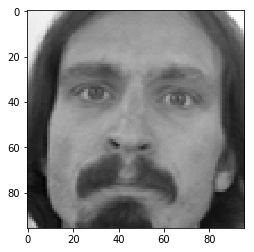

In [4]:
plt.imshow(train_img[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
#获取关键点坐标
train_y = train_pd.iloc[:, :-1].values
print(train_y.shape)
print(train_y[1, :])

(2140, 30)
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


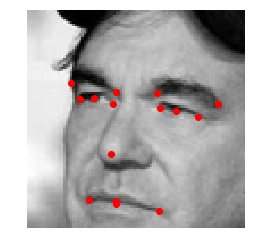

In [6]:
#将关键点和图像相融合
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        #np.vstack(np.split(y, 15))先切分成15组，再按组相连 
        #[1, 2, 3, 4,, 5, 6]=>[1, 2,],[3, 4], [5, 6]=>[[1,2], [3, 4], [5, 6]]
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_y[sample_idx])

In [7]:
#数据预处理
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)#random_state：是随机数的种子
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(1712, 96, 96, 1) (428, 96, 96, 1)
(30,)


In [8]:
#定义模型
def model(input):
    with tf.variable_scope('layer1'):
        conv1 = tf.layers.conv2d(input, 32, 3, strides=1, padding='SAME')
        relu1 = tf.nn.relu(conv1)
        pool1 = tf.layers.max_pooling2d(relu1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer2'):
        conv2 = tf.layers.conv2d(pool1, 64, 2, strides=1, padding='SAME')
        relu2= tf.nn.relu(conv2)
        pool2 = tf.layers.max_pooling2d(relu2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        conv3 = tf.layers.conv2d(pool2, 128, 2, strides=1, padding='SAME')
        relu3 = tf.nn.relu(conv3)
        pool3 = tf.layers.max_pooling2d(relu3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 12*12*128])
        layer4 = tf.layers.dense(flatten, 1024)
        relu4 = tf.nn.relu(layer4)
        drop4 = tf.layers.dropout(relu4, 0.5)
    with tf.variable_scope('layer5'):
        layer5 = tf.layers.dense(drop4, 1024)
        relu5 = tf.nn.relu(layer5)
        output = tf.layers.dense(relu5, 30)
    return output

In [11]:
#训练
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
out = model(x_data)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=y_data))
train_step = tf.train.AdadeltaOptimizer(0.1).minimize(loss)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 20
    batch_size = 100
    num_batch = len(x_train) // batch_size
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*num_batch : (i+1)*num_batch]
            y_batch = y_train[i*num_batch : (i+1)*num_batch]
            _, loss_step = sess.run([train_step, loss], \
                              feed_dict={x_data:x_batch, y_data:y_batch})
            if(i == 0):
                print(n, loss_step)
    saver.save(sess, ckpt_path)

0 31020.074
1 29625756.0
2 4.3291066e+18
3 8.920937e+25
4 2.56182e+26
5 4.203625e+26
6 5.8488793e+26
7 7.495416e+26
8 9.144663e+26
9 1.07972475e+27
10 1.2454235e+27
11 1.411444e+27
12 1.5777723e+27
13 1.7442537e+27
14 1.9108902e+27
15 2.0777682e+27
16 2.2447918e+27
17 2.4118331e+27
18 2.5788206e+27
19 2.7457784e+27
